In [64]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.contrib.wrapper import wrap,CLASSIFIER
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV

import scorecardpy as sc

from category_encoders.target_encoder import TargetEncoder

import shap
import numpy as np

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import RFE
from yellowbrick.classifier.classification_report import classification_report

# print the JS visualization code to the notebook
shap.initjs()

In [3]:
df = pd.read_excel("../../data/default of credit card clients.xls",\
                  skiprows=[0],\
                  header=0,
                  index_col='ID')
df.rename(columns={'default payment next month': 'default'}, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [10]:
categorical_cols = [f'PAY_{i}' for i in [0, 2, 3, 4, 5, 6]]
df.loc[:,df.columns.isin(categorical_cols)] = df.loc[:,df.columns.isin(categorical_cols)].apply(
                                                                                    pd.Categorical
                                                                                    )
categorical_cols

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [11]:
df.head().dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
dtype: object

In [63]:
df.default.value_counts()[1]/df.default.value_counts()[0]

0.2840267077555213

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
                                                df.loc[:,~df.columns.isin(['default'])], 
                                                df['default'], 
                                    test_size=0.33, random_state=42, stratify=df['default'])

In [53]:
categorical_indices = [X_train.columns.get_loc(each_categorical_col) for each_categorical_col in categorical_cols]
categorical_indices

[5, 6, 7, 8, 9, 10]

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_encoder', TargetEncoder(cols=categorical_cols), categorical_cols),
        ],\
    remainder = 'passthrough'
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
gbm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LGBMClassifier(scale_pos_weight=1/22))])

In [62]:
gbm = LGBMClassifier(is_unbalance=False,scale_pos_weight=22)
gbm.fit(X_train,y_train,categorical_feature=categorical_indices)

Using categorical_feature in Dataset.


LGBMClassifier(is_unbalance=False, scale_pos_weight=22)

In [55]:

gbm.fit(X_train,y_train)

LGBMClassifier(is_unbalance=True)

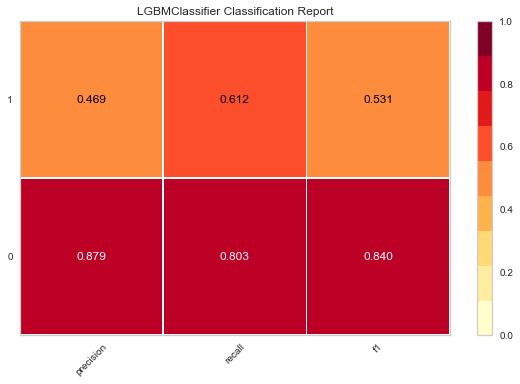

In [56]:

classification_report(gbm, X_train, y_train, X_test, y_test,is_fitted=True)
plt.show()

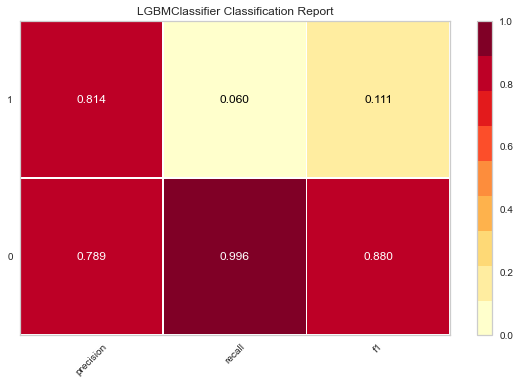

In [61]:

classification_report(gbm, X_train, y_train, X_test, y_test,is_fitted=True)
plt.show()

In [22]:
continious_cols = list(set(df.columns.tolist()).difference(categorical_cols).difference(set(['default'])))
continious_cols

['BILL_AMT6',
 'PAY_AMT4',
 'AGE',
 'BILL_AMT1',
 'MARRIAGE',
 'EDUCATION',
 'PAY_AMT2',
 'PAY_AMT3',
 'BILL_AMT3',
 'BILL_AMT5',
 'PAY_AMT5',
 'SEX',
 'BILL_AMT4',
 'PAY_AMT6',
 'BILL_AMT2',
 'PAY_AMT1',
 'LIMIT_BAL']

In [23]:
probas = gbm.predict_proba(X_train)[:,1]
probas= np.argwhere((probas>=0.51) & (probas<=0.52)).flatten()
probas

array([   75,   181,   268,   323,   434,   452,   508,   512,   678,
         712,   755,   790,   817,   855,   879,  1040,  1073,  1084,
        1182,  1190,  1362,  1623,  1639,  1684,  1739,  1843,  2022,
        2047,  2120,  2168,  2203,  2315,  2335,  2469,  2576,  2748,
        2804,  2973,  3192,  3243,  3285,  3374,  3436,  3898,  4005,
        4126,  4156,  4405,  4756,  5112,  5146,  5433,  5628,  5735,
        5778,  5962,  6029,  6139,  6218,  6290,  6341,  6421,  6532,
        6987,  7254,  7256,  7392,  7448,  7619,  7695,  7873,  7876,
        8175,  8287,  8408,  8445,  8736,  8782,  8890,  8997,  9070,
        9289,  9293,  9332,  9364,  9540,  9617,  9686,  9808,  9928,
        9997, 10034, 10057, 10069, 10106, 10216, 10238, 10415, 10798,
       10811, 10878, 10896, 11198, 11357, 11386, 11531, 11721, 11943,
       12020, 12062, 12114, 12244, 12388, 12602, 12806, 12856, 12873,
       12876, 12959, 13084, 13208, 13222, 13358, 13470, 13479, 13492,
       13741, 13881,

In [24]:

X_train = pd.DataFrame(gbm["preprocessor"].transform(X_train))
X_train.columns = gbm["preprocessor"].get_feature_names()

explainer = shap.TreeExplainer(gbm["classifier"],X_train)
shap_values = explainer.shap_values(X_train)


100%|===================| 20039/20100 [00:48<00:00]        

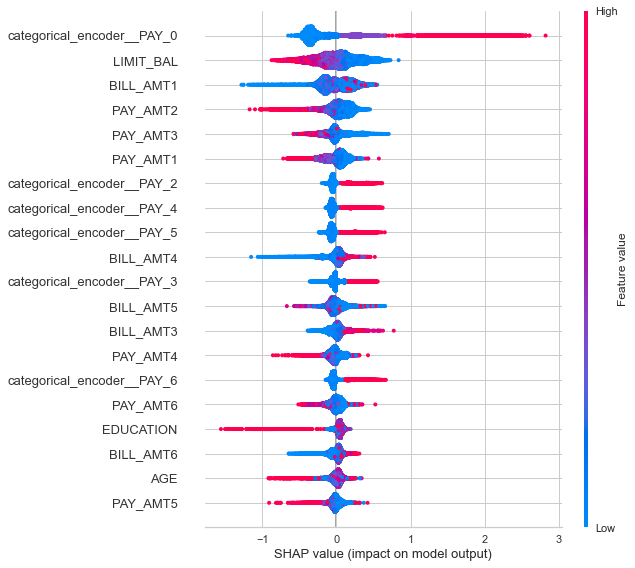

In [25]:
shap.summary_plot(shap_values, X_train)

In [47]:


d = dice_ml.Data(dataframe=df,
                 continuous_features=continious_cols,
                 outcome_name='default')
# Pre-trained ML model
m = dice_ml.Model(model=gbm, backend='sklearn')
# DiCE explanation instance
exp = dice_ml.Dice(d,m)

In [48]:
query_instance = df.iloc[0].to_dict()
del query_instance["default"]
query_instance

{'LIMIT_BAL': 20000,
 'SEX': 2,
 'EDUCATION': 2,
 'MARRIAGE': 1,
 'AGE': 24,
 'PAY_0': '2',
 'PAY_2': '2',
 'PAY_3': '-1',
 'PAY_4': '-1',
 'PAY_5': '-2',
 'PAY_6': '-2',
 'BILL_AMT1': 3913,
 'BILL_AMT2': 3102,
 'BILL_AMT3': 689,
 'BILL_AMT4': 0,
 'BILL_AMT5': 0,
 'BILL_AMT6': 0,
 'PAY_AMT1': 0,
 'PAY_AMT2': 689,
 'PAY_AMT3': 0,
 'PAY_AMT4': 0,
 'PAY_AMT5': 0,
 'PAY_AMT6': 0}

In [49]:
dice_exp = exp.generate_counterfactuals(df.iloc[0:1,:-1], total_CFs=2, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

Query instance (original outcome : 1)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1



Diverse Counterfactual set (new outcome: 0.0)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,154176.0,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,162052.0,0,0,0
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,447847.0,0,0,0


In [65]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [67]:
dt_s = sc.var_filter(df, y="default")

[INFO] filtering variables ...
Variable filtering on 30000 rows and 24 columns in 00:01:05 
2 variables are removed


In [68]:
train, test = sc.split_df(dt_s, 'default').values()

# woe binning ------
bins = sc.woebin(dt_s, y="default")

[INFO] creating woe binning ...


In [71]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train,bins)
test_woe = sc.woebin_ply(test,bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [72]:
y_train = train_woe.loc[:,'default']
X_train = train_woe.loc[:,train_woe.columns != 'default']
y_test = test_woe.loc[:,'default']
X_test = test_woe.loc[:,train_woe.columns != 'default']

# logistic regression ------
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.9, n_jobs=-1, penalty='l1', solver='saga')

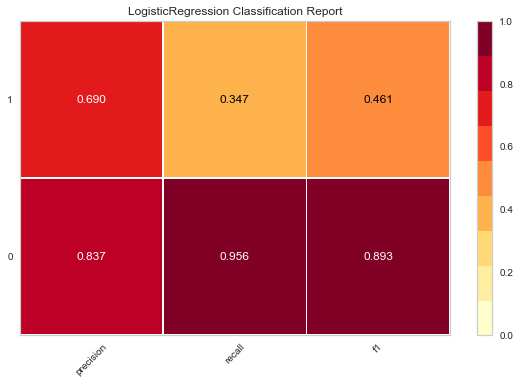

In [73]:

classification_report(lr, X_train, y_train, X_test, y_test,is_fitted=True)
plt.show()

In [79]:
explainer = shap.LinearExplainer(lr,X_train)
shap_values = explainer.shap_values(X_train)

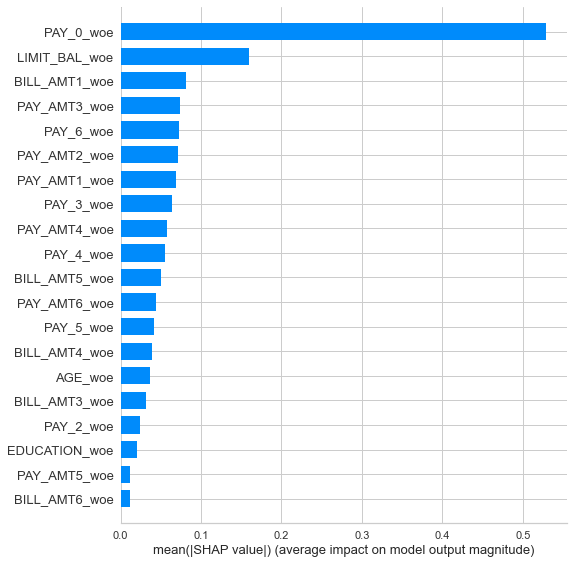

In [91]:
shap.summary_plot(shap_values, X_train,plot_type="bar")